In [1]:
import os
from dotenv import load_dotenv 
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

load_dotenv()

True

In [2]:
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [3]:
embeddings = HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")

e:\2025\Generative_AI\Course\agentic-ai-2.0\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
result = embeddings.embed_query("hi how are you")
len(result)

384

In [5]:
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [6]:
result = embeddings.embed_query("how are you")
len(result)

768

In [7]:
from pinecone import Pinecone
from pinecone import ServerlessSpec
# serverless: Server will be managed by cloud provider
from langchain_pinecone.vectorstores import PineconeVectorStore

In [8]:
pinecone_api_key = os.getenv('PINECONE_API_KEY')

In [9]:
pc = Pinecone(api_key=pinecone_api_key)

In [10]:
index_name = "agenticai"

# create index
if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    
# load index
index = pc.Index(index_name)

In [11]:
index

In [12]:
vector_store = PineconeVectorStore(index=index, embedding=embeddings)

In [14]:
from uuid import uuid4

from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocolate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
)

documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]
uuids = [str(uuid4()) for _ in range(len(documents))]
vector_store.add_documents(documents=documents, ids=uuids)

['3408eece-4112-4fc6-9863-b9f9c270d622',
 '762afe0d-93b0-4004-876d-460e33f4fac4',
 '7ba6d1d7-9867-4a62-9812-248cdcf38a61',
 'b52235c6-3f3e-4320-a6dc-49baff38ca69',
 '860de79b-e4f8-498e-8374-023905f6488b',
 '3d65957e-4c4f-49bc-b3c2-a815614bd020',
 '9762cf01-9702-498d-9ae0-c6adf9184ee6',
 'f91271ca-09f3-4f3c-956f-07c6c63eb980',
 '36fc0d98-36d4-44be-ae4a-c8d3a2c2bdc4',
 'fa579985-713d-4b47-a85f-0863d04fe20b']

In [15]:
vector_store.similarity_search("will it be hot tomorrow?", k=1, filter={"source": "news"})

[Document(id='39cf3926-8b26-44ed-b5bc-487830d9af37', metadata={'source': 'news'}, page_content='The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.')]

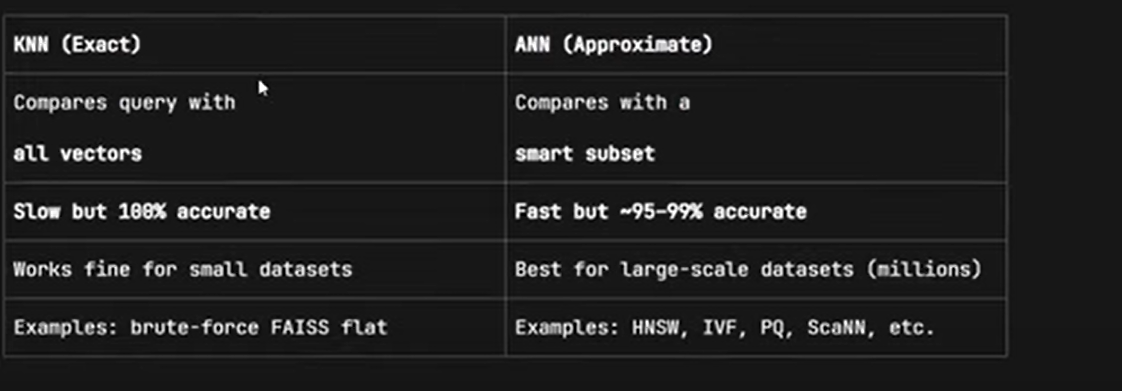

In [16]:
retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 3, "score_threshold":0.5}
)

In [18]:
retriever.invoke("what's the weather")

[Document(id='5884a382-c36a-4140-b3d2-de6e934f00b9', metadata={'source': 'news'}, page_content='The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.'),
 Document(id='ba17e928-0c48-4e53-95c8-8f482ffc3cf5', metadata={'source': 'news'}, page_content='The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.'),
 Document(id='39cf3926-8b26-44ed-b5bc-487830d9af37', metadata={'source': 'news'}, page_content='The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.')]

In [19]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableMap
from langchain_core.output_parsers import StrOutputParser

template=""" 
    You are an ai assistant. Answer the following question based on provided context only.
    context: {context}
    question: {query}
    """

prompt = PromptTemplate(
    template=template,
    input_variables=["context", "query"]
)

In [20]:
# from langchain_core.prompts import ChatPromptTemplate

# prompt = ChatPromptTemplate(
#     [
#         ("system", "You are a ai assistant provide the answer based on the provided context only {context}"),
#         ("user", "{query}")
#     ]
# )

In [21]:
from langchain_groq.chat_models import ChatGroq

groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")

In [22]:
def format_doc(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
chain = ({"context": retriever | format_doc, "query": RunnablePassthrough()}
         | prompt 
         | llm 
         | StrOutputParser()
         )

In [27]:
# chain.invoke({"query":"What will the weather today?"})

chain.invoke("What will the weather today?")

'This document does not contain the answer to what the weather will be like today. It only contains weather forecasts for tomorrow. \n'